In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
station = Base.classes.station
measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
station_column = [column.name for column in station.__table__.columns]
print(station_column)
measurement_column = [column.name for column in measurement.__table__.columns]
print(measurement_column)

['id', 'station', 'name', 'latitude', 'longitude', 'elevation']
['id', 'station', 'date', 'prcp', 'tobs']


In [10]:
# Find the most recent date in the data set.
most_recent = session.query(measurement).order_by(measurement.date.desc()).first()
print(most_recent.date)

2017-08-23


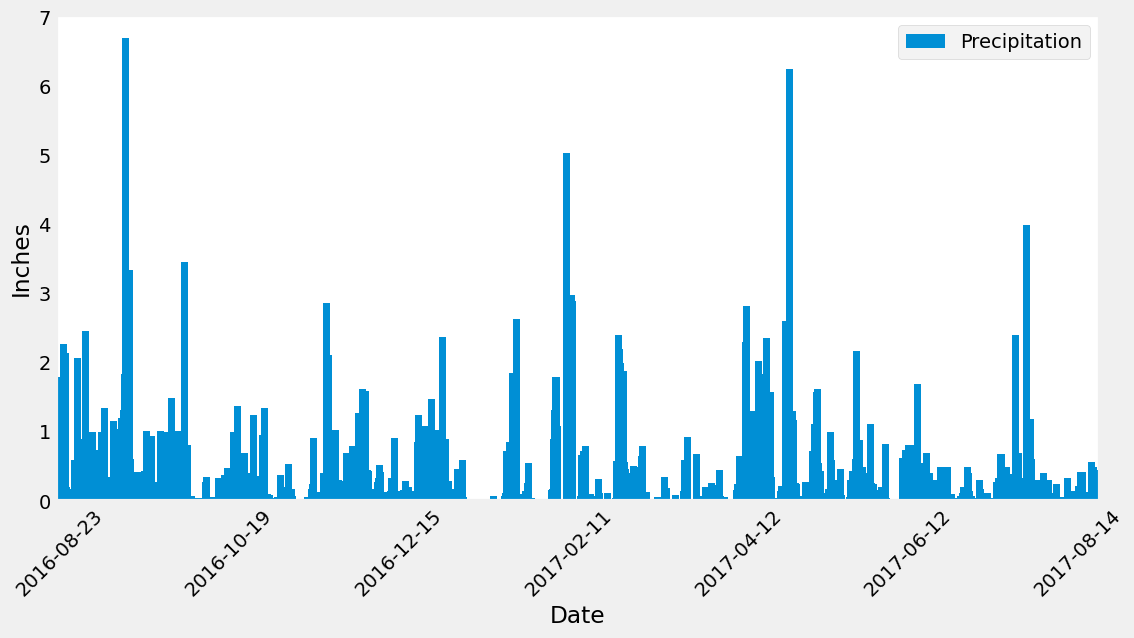

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
end_date = most_recent.date
end_date = dt.datetime.strptime(end_date, '%Y-%m-%d')

# Calculate the date one year from the last date in data set.
start_date = end_date - dt.timedelta(days=365)
end_date = end_date.strftime('%Y-%m-%d')
start_date = start_date.strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
last_twelve = session.query(measurement).\
    filter(measurement.date >= start_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
last_twelve_result = []
for x in last_twelve:
     last_twelve_result.append((x.date, x.prcp))
last_twelve_df = pd.DataFrame(last_twelve_result, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
last_twelve_df = last_twelve_df.sort_values(by='Date', ascending=True).reset_index()

# Use Pandas Plotting with Matplotlib to plot the data
rain_plot = last_twelve_df.plot(kind='bar', x='Date', y='Precipitation', 
                    xlabel='Date', 
                    ylabel='Inches',
                    figsize=(12, 6), 
                    width=15, 
                    grid=False
                   )
rain_plot.set_xticks(last_twelve_df.index[::365])
rain_plot.set_xticklabels(last_twelve_df["Date"][::365], rotation=45);
rain_plot.set_facecolor('white')

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
last_twelve_df[['Precipitation']].describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [32]:
# Design a query to calculate the total number of stations in the dataset
station_qty = session.query(station).group_by(station.station).count()
print(station_qty)

9


In [57]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_activity = session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).all()
station_activity.sort(key=lambda x: x[1], reverse=True)
for y in station_activity:
    print(y)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [70]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = station_activity[0][0]
most_active_summary = session.query(func.min(measurement.tobs),
                                    func.max(measurement.tobs),
                                    func.avg(measurement.tobs)
                                   ).\
    filter(measurement.station == most_active).all()
print(most_active_summary)

[(54.0, 85.0, 71.66378066378067)]


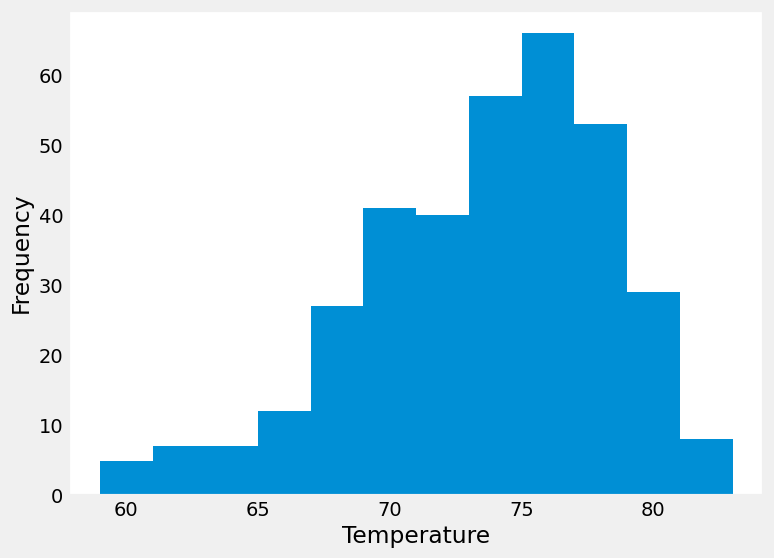

In [93]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_py = session.query(measurement.tobs).\
    filter(measurement.station == most_active, 
           measurement.date >= start_date).all()
most_active_py_df = pd.DataFrame(most_active_py)
maspy_hist = most_active_py_df['tobs'].plot(kind='hist', 
                                            y='tobs', 
                                            bins=12, 
                                            xlabel='Temperature', 
                                            figsize=(8, 6), 
                                            grid=False
                                           )
maspy_hist.set_facecolor('white')

# Close Session

In [16]:
# Close Session
session.close()